# Import

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LightSource
from matplotlib import cbook, cm

import torch
from torch import nn, optim  
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal

from tqdm import tqdm
import random

# Model Architecture Definition

## Proposed Method

### ExU Module : weight & bias transformation module

In [175]:
class ExU(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(ExU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=3, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.zeros(self.weights.shape)
        monotonic_weights = torch.exp(self.weights)
        output = (inputs.matmul(monotonic_weights) - (self.bias)*(monotonic_weights))
        
        return output

### NAMs with 1 dim Architecture

In [170]:
class ExNN(nn.Module):
    def __init__(
        self,
        _input_shape: int,
        _output_shape: int,
        _hidden_shape: list,
    ) -> None:
        super(ExNN, self).__init__()

        self._input_shape = _input_shape
        self._output_shape = _output_shape
        self._hidden_shape = _hidden_shape
        self._hidden_len = len(_hidden_shape)

        self.exu_layer = nn.Sequential(
            ExU(in_features=self._input_shape, out_features=self._hidden_shape[0]),
            nn.ReLU()
        )

        for hidden_idx in range(self._hidden_len - 1):
            exec(f"self.hidden_layer{hidden_idx} = nn.Sequential(nn.Linear(in_features=self._hidden_shape[hidden_idx], out_features=self._hidden_shape[hidden_idx+1]),nn.ReLU())")
        
        self.last_layer = nn.Sequential(
            nn.Linear(in_features=self._hidden_shape[-1], out_features=self._output_shape)
        )

        
    def forward(self, inputs) -> torch.Tensor:
        outputs = self.exu_layer(inputs)
        for hidden_idx in range(self._hidden_len - 1):
            exec(f"outputs = self.hidden_layer{hidden_idx}(outputs)")
        outputs = self.last_layer(outputs)
        
        return outputs

## Comparison Method

### MLP Architecture

In [171]:
class MLP(nn.Module):
    def __init__(
        self,
        _input_shape: int,
        _output_shape: int,
        _hidden_shape: list,
    ) -> None:
        super(MLP, self).__init__()

        self._input_shape = _input_shape
        self._output_shape = _output_shape
        self._hidden_shape = _hidden_shape
        self._hidden_len = len(_hidden_shape)

        self.first_layer = nn.Sequential(
            nn.Linear(in_features=self._input_shape, out_features=self._hidden_shape[0]),
            nn.ReLU()
        )

        for hidden_idx in range(self._hidden_len - 1):
            exec(f"self.hidden_layer{hidden_idx} = nn.Sequential(nn.Linear(in_features=self._hidden_shape[hidden_idx], out_features=self._hidden_shape[hidden_idx+1]),nn.ReLU())")
        
        self.last_layer = nn.Sequential(
            nn.Linear(in_features=self._hidden_shape[-1], out_features=self._output_shape)
        )

        
    def forward(self, inputs) -> torch.Tensor:
        outputs = self.first_layer(inputs)
        for hidden_idx in range(self._hidden_len - 1):
            exec(f"outputs = self.hidden_layer{hidden_idx}(outputs)")
        outputs = self.last_layer(outputs)
        
        return outputs

# Experiment Setting

Text(0.5, 1.0, 'Dataset')

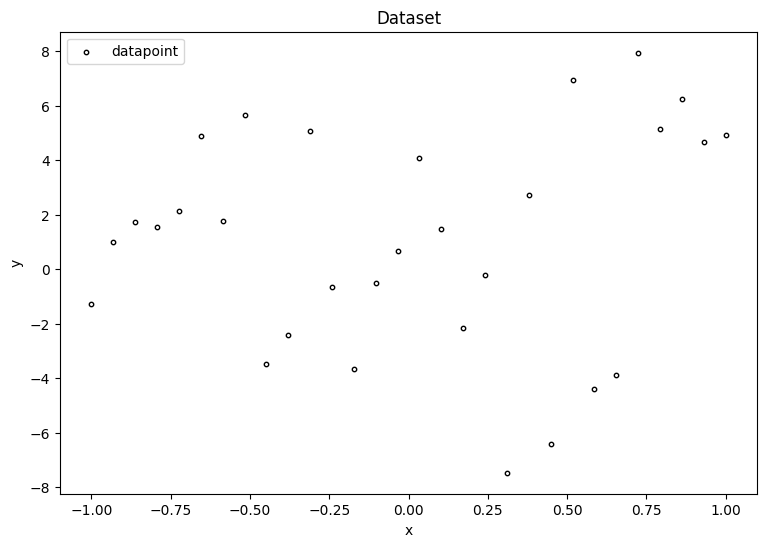

In [158]:
plt.figure(figsize=(9,6))

x = np.linspace(-1.,1.,30)
y = x+np.array(Normal(0, 5).sample(x.shape))

plt.scatter(x=x, y=y, edgecolors='black', c='white', s=10, label='datapoint', zorder=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Dataset')


# Experiment

In [159]:
device = 'cuda'

In [172]:
train_x = torch.tensor(x.reshape(-1,1)).type(torch.float32).to(device)
train_y = torch.tensor(y.reshape(-1,1)).type(torch.float32).to(device)

## Experiment1 - Clone Experiments

In [178]:
MLP_model = MLP(_input_shape=1, _output_shape=1, _hidden_shape=[1024]).to(device)
ExU_model = ExNN(_input_shape=1, _output_shape=1, _hidden_shape=[1024]).to(device)

MLP_optimizer = optim.Adam(MLP_model.parameters(), lr = 1e-3)
ExU_optimizer = optim.Adam(ExU_model.parameters(), lr = 1e-3)

MLP_model.train()
ExU_model.train()


for epoch in range(10000):
    MLP_optimizer.zero_grad()
    MLP_loss = nn.MSELoss()(MLP_model(train_x), train_y)
    MLP_loss.backward()
    MLP_optimizer.step()

    ExU_optimizer.zero_grad()
    ExU_loss = nn.MSELoss()(ExU_model(train_x), train_y)
    ExU_loss.backward()
    ExU_optimizer.step()

    if epoch%100==99:
        print(f"[epoch{epoch}] MLP mse: {round(MLP_loss.detach().item(),4)}, ExU mse: {round(ExU_loss.detach().item(),4)}")


[epoch99] MLP mse: 12.7572, ExU mse: 11.2787
[epoch199] MLP mse: 11.7953, ExU mse: 10.1958
[epoch299] MLP mse: 11.5644, ExU mse: 9.3758
[epoch399] MLP mse: 11.4627, ExU mse: 8.7098
[epoch499] MLP mse: 11.3509, ExU mse: 8.0742
[epoch599] MLP mse: 11.2134, ExU mse: 7.4067
[epoch699] MLP mse: 11.0545, ExU mse: 6.7784
[epoch799] MLP mse: 10.8786, ExU mse: 6.3253
[epoch899] MLP mse: 10.694, ExU mse: 5.9603
[epoch999] MLP mse: 10.5111, ExU mse: 5.6536
[epoch1099] MLP mse: 10.3348, ExU mse: 5.3731
[epoch1199] MLP mse: 10.165, ExU mse: 5.1408
[epoch1299] MLP mse: 9.9986, ExU mse: 4.8555
[epoch1399] MLP mse: 9.83, ExU mse: 4.6404
[epoch1499] MLP mse: 9.6574, ExU mse: 4.4017
[epoch1599] MLP mse: 9.4823, ExU mse: 4.1893
[epoch1699] MLP mse: 9.3273, ExU mse: 4.0029
[epoch1799] MLP mse: 9.1867, ExU mse: 3.81
[epoch1899] MLP mse: 9.0579, ExU mse: 3.6363
[epoch1999] MLP mse: 8.9355, ExU mse: 3.4753
[epoch2099] MLP mse: 8.8182, ExU mse: 3.3215
[epoch2199] MLP mse: 8.7047, ExU mse: 3.1811
[epoch2299] M

## Result - Clone Experiments

Text(0.5, 1.0, 'Dataset')

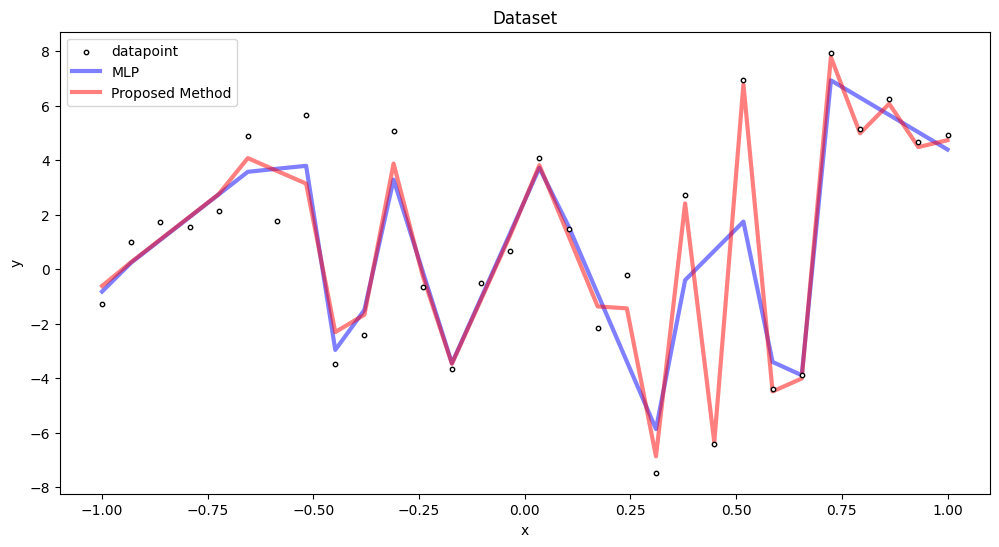

In [179]:
plt.figure(figsize=(12,6))

plt.scatter(x=x, y=y, edgecolors='black', c='white', s=10, label='datapoint', zorder=3)
plt.plot(x, MLP_model(train_x).to('cpu').detach().numpy(), c='blue', zorder=1, label='MLP', alpha=0.5, linewidth=3)
plt.plot(x, ExU_model(train_x).to('cpu').detach().numpy(), c='red', zorder=2, label='Proposed Method', alpha=0.5, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Dataset')


## Experiments2 - Deep & Narrow Setting

In [184]:
MLP_model = MLP(_input_shape=1, _output_shape=1, _hidden_shape=[64,64,64,64]).to(device)
ExU_model = ExNN(_input_shape=1, _output_shape=1, _hidden_shape=[64,64,64,64]).to(device)

MLP_optimizer = optim.Adam(MLP_model.parameters(), lr = 1e-3)
ExU_optimizer = optim.Adam(ExU_model.parameters(), lr = 1e-3)

MLP_model.train()
ExU_model.train()


for epoch in range(20000):
    MLP_optimizer.zero_grad()
    MLP_loss = nn.MSELoss()(MLP_model(train_x), train_y)
    MLP_loss.backward()
    MLP_optimizer.step()

    ExU_optimizer.zero_grad()
    ExU_loss = nn.MSELoss()(ExU_model(train_x), train_y)
    ExU_loss.backward()
    ExU_optimizer.step()

    if epoch%100==99:
        print(f"[epoch{epoch}] MLP mse: {round(MLP_loss.detach().item(),4)}, ExU mse: {round(ExU_loss.detach().item(),4)}")


[epoch99] MLP mse: 15.2626, ExU mse: 14.4112
[epoch199] MLP mse: 14.459, ExU mse: 13.5979
[epoch299] MLP mse: 13.7155, ExU mse: 12.9174
[epoch399] MLP mse: 13.1108, ExU mse: 12.4693
[epoch499] MLP mse: 12.6923, ExU mse: 12.1716
[epoch599] MLP mse: 12.4486, ExU mse: 11.9998
[epoch699] MLP mse: 12.2819, ExU mse: 11.8772
[epoch799] MLP mse: 12.1437, ExU mse: 11.7551
[epoch899] MLP mse: 12.0396, ExU mse: 11.6201
[epoch999] MLP mse: 11.9499, ExU mse: 11.4573
[epoch1099] MLP mse: 11.8733, ExU mse: 11.281
[epoch1199] MLP mse: 11.8141, ExU mse: 11.1061
[epoch1299] MLP mse: 11.7695, ExU mse: 10.9209
[epoch1399] MLP mse: 11.728, ExU mse: 10.6962
[epoch1499] MLP mse: 11.6939, ExU mse: 10.4202
[epoch1599] MLP mse: 11.6621, ExU mse: 10.1085
[epoch1699] MLP mse: 11.6321, ExU mse: 9.8113
[epoch1799] MLP mse: 11.6028, ExU mse: 9.5852
[epoch1899] MLP mse: 11.5742, ExU mse: 9.4378
[epoch1999] MLP mse: 11.5456, ExU mse: 9.3409
[epoch2099] MLP mse: 11.5162, ExU mse: 9.271
[epoch2199] MLP mse: 11.4855, ExU

# Result

Text(0.5, 1.0, 'Dataset')

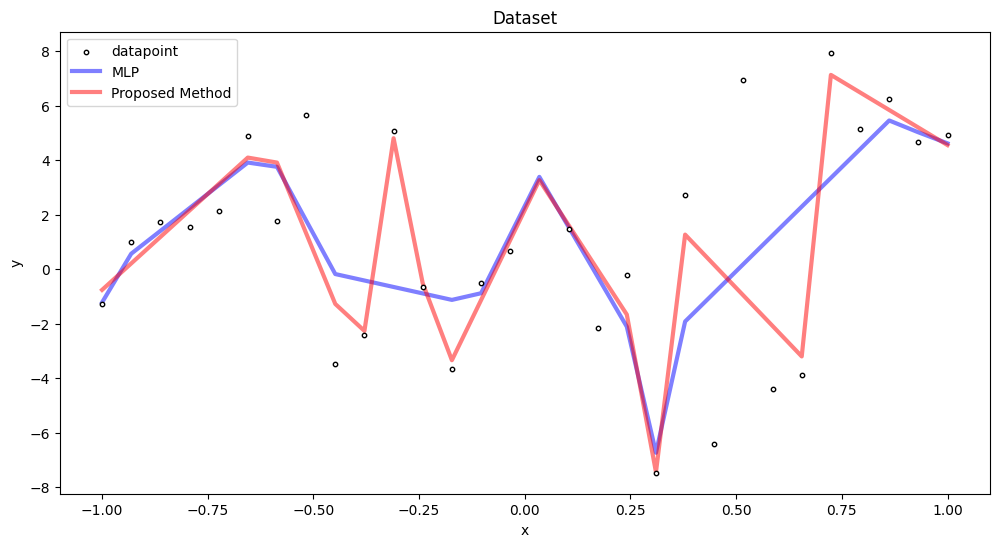

In [185]:
plt.figure(figsize=(12,6))

plt.scatter(x=x, y=y, edgecolors='black', c='white', s=10, label='datapoint', zorder=3)
plt.plot(x, MLP_model(train_x).to('cpu').detach().numpy(), c='blue', zorder=1, label='MLP', alpha=0.5, linewidth=3)
plt.plot(x, ExU_model(train_x).to('cpu').detach().numpy(), c='red', zorder=2, label='Proposed Method', alpha=0.5, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Dataset')
